<a href="https://colab.research.google.com/github/CarmenTheodoraCraciun/Sleep-Quality-Based-EEG-Signals/blob/main/3_Sleep_Qulity_UCD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Systems for Sleep Quality Assessment Based on EEG Signals

---

* **Author**: Carmen-Theodora Craciun
* **Status**: Done
* **Previos step**: None
* **The purpose of this Notebook**:
* **Dataset**: [University College Dublin Sleep Apnea Database (PhysioNet)](https://physionet.org/content/ucddb/1.0.0/)
  * patients diagnosed with apnea, who do not suffer from cardiological diseases or autonomic dysfunctions and are not taking medication at the time of registration.
* **Input**: None.
* **Output:**
    * Folders train, val and test.

#Importing

In [10]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 37.8 MB/s eta 0:00:00


In [36]:
from google.colab import drive
import os
import requests
import shutil
import os
import mne
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
import glob
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
mne.set_log_level('ERROR')

In [16]:
drive.mount('/content/drive')

base_path = '/content/drive/MyDrive/sleep_data/raw_dataset'
original_dir = '/content/ucd'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Download

In [7]:
def download_ucd_subject(subject_id, output_dir):
    '''Download UCD Apnea Dataset'''
    base_url = "https://physionet.org/files/ucddb/1.0.0/"

    files_to_fetch = [f"{subject_id}.rec", f"{subject_id}_stage.txt"]

    for filename in files_to_fetch:
        url = base_url + filename
        local_path = os.path.join(output_dir, filename)

        # Rename rec -> edf
        if filename.endswith(".rec"):
            final_edf_name = filename.replace(".rec", ".edf")
            final_path = os.path.join(output_dir, final_edf_name)

            if os.path.exists(final_path):
                continue

            print(f"Downloading {filename}...")
            try:
                r = requests.get(url, stream=True)
                if r.status_code == 200:
                    with open(local_path, 'wb') as f:
                        for chunk in r.iter_content(chunk_size=1024):
                            f.write(chunk)

                    # Redenumire critică pentru MNE direct pe Drive
                    print(f"   > Renaming to {final_edf_name}...")
                    os.rename(local_path, final_path)
                else:
                    print(f"File not found on server (Status: {r.status_code})")
            except Exception as e:
                print(f"Error: {e}")

        # hypno
        else:
            if os.path.exists(local_path):
                continue

            print(f"Downloading {filename}")
            try:
                r = requests.get(url, stream=True)
                if r.status_code == 200:
                    with open(local_path, 'wb') as f:
                        for chunk in r.iter_content(chunk_size=1024):
                            f.write(chunk)
                else:
                    print(f"File not found (Status: {r.status_code})")
            except Exception as e:
                print(f"Error: {e}")

In [9]:
ucd_output_dir = os.path.join(base_path, "ucd")

if not os.path.exists(ucd_output_dir):
    os.makedirs(ucd_output_dir)

ucd_subjects = [f"ucddb{i:03d}" for i in range(2, 29)]

for subj in ucd_subjects:
    download_ucd_subject(subj, ucd_output_dir)
print(f"\nDone! Files downloaded at: {ucd_output_dir}")

   > Renaming to ucddb003.edf...
File not found on server (Status: 404)
File not found (Status: 404)
   > Renaming to ucddb005.edf...
   > Renaming to ucddb006.edf...
   > Renaming to ucddb007.edf...
   > Renaming to ucddb008.edf...
   > Renaming to ucddb009.edf...
   > Renaming to ucddb010.edf...
   > Renaming to ucddb011.edf...
   > Renaming to ucddb012.edf...
   > Renaming to ucddb013.edf...
   > Renaming to ucddb014.edf...
   > Renaming to ucddb015.edf...
File not found on server (Status: 404)
File not found (Status: 404)
   > Renaming to ucddb017.edf...
   > Renaming to ucddb018.edf...
   > Renaming to ucddb019.edf...
   > Renaming to ucddb020.edf...
   > Renaming to ucddb021.edf...
   > Renaming to ucddb022.edf...
   > Renaming to ucddb023.edf...
   > Renaming to ucddb024.edf...
   > Renaming to ucddb025.edf...
   > Renaming to ucddb026.edf...
   > Renaming to ucddb027.edf...
   > Renaming to ucddb028.edf...

Done! Files downloaded at: /content/drive/MyDrive/sleep_data/raw_datase

#Vizualization

In [14]:
def vizualization(base_path, subject_id):
    edf_path = os.path.join(base_path, f"{subject_id}.edf")
    txt_path = os.path.join(base_path, f"{subject_id}_stage.txt")

    # 1. Load and Inspect EDF Metadata
    print(f"File: {edf_path}")

    # MNE reads the header without loading everything into RAM (preload=False at the beginning)
    raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)

    print("\n--- General info ---")
    print(f"Sampling Rate: {raw.info['sfreq']} Hz")
    print(f"Number of channels: {len(raw.ch_names)}")
    print(f"Channel names: {raw.ch_names}")
    print(f"Recording time: {raw.times[-1] / 3600:.2f} hours")

    # 2. Identifying the EEG Channel (C3-A2)
    # We search for the channel that contains "C3"
    target_ch = [ch for ch in raw.ch_names if "C3" in ch][0]
    print(f"\nChannel selected: {target_ch}")

    # 3. Raw Signal Visualization (30 seconds)
    start_sec = 1000  # We start from second 1000 (to ensure the subject is asleep)
    duration = 30     # One epoch
    fs = int(raw.info['sfreq'])

    # Extract the data: start and end indices
    start_idx = int(start_sec * fs)
    end_idx = int((start_sec + duration) * fs)

    data, times = raw[target_ch, start_idx:end_idx]
    # MNE returns (n_channels, n_samples), we take the first channel [0]
    signal = data[0] * 1e6  # Convert from Volts to Microvolts (uV) for readability

    plt.figure(figsize=(15, 4))
    plt.plot(times, signal, color='#2c3e50', linewidth=0.8)
    plt.title(f"Raw EEG Signal ({target_ch}) - 30 seconds (Start: {start_sec}s)")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude (uV)")
    plt.grid(True, alpha=0.3)
    plt.show()

    # 4. Hypnogram Visualization (Sleep Stages)
    print(f"\nHypnogram file: {txt_path}")

    # Load the text file (one digit per line, each line = 30 seconds)
    hypnogram = np.loadtxt(txt_path, dtype=int)

    # Create the time axis for the hypnogram (in hours)
    # Each point represents 30 seconds = 30/3600 hours
    time_hours = np.arange(len(hypnogram)) * 30 / 3600

    plt.figure(figsize=(15, 5))
    plt.step(time_hours, hypnogram, where='post', color='#e74c3c')

    # UCD-specific settings (Here we see the difference from Sleep-EDF!)
    # UCD: 0=Wake, 1=REM, 2=S1, 3=S2, 4=S3, 5=S4
    plt.yticks([0, 1, 2, 3, 4, 5], ['Wake (0)', 'REM (1)', 'S1 (2)', 'S2 (3)', 'S3 (4)', 'S4 (5)'])
    plt.gca().invert_yaxis()  # Invert Y-axis to look like a classic hypnogram (Wake at the top)
    plt.title(f"Hypnogram of Patient {subject_id} (Original UCD Format)")
    plt.xlabel("Time (Hours)")
    plt.grid(True, alpha=0.3)
    plt.show()
def vizualization(base_path, subject_id):
    edf_path = os.path.join(base_path, f"{subject_id}.edf")
    txt_path = os.path.join(base_path, f"{subject_id}_stage.txt")

    # 1. Load and Inspect EDF Metadata
    print(f"File: {edf_path}")

    # MNE reads the header without loading everything into RAM (preload=False at the beginning)
    raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)

    print("\n--- General info ---")
    print(f"Sampling Rate: {raw.info['sfreq']} Hz")
    print(f"Number of channels: {len(raw.ch_names)}")
    print(f"Channel names: {raw.ch_names}")
    print(f"Recording time: {raw.times[-1] / 3600:.2f} hours")

    # 2. Identifying the EEG Channel (C3-A2)
    # We search for the channel that contains "C3"
    target_ch = [ch for ch in raw.ch_names if "C3" in ch][0]
    print(f"\nChannel selected: {target_ch}")

    # 3. Raw Signal Visualization (30 seconds)
    start_sec = 1000  # We start from second 1000 (to ensure the subject is asleep)
    duration = 30     # One epoch
    fs = int(raw.info['sfreq'])

    # Extract the data: start and end indices
    start_idx = int(start_sec * fs)
    end_idx = int((start_sec + duration) * fs)

    data, times = raw[target_ch, start_idx:end_idx]
    # MNE returns (n_channels, n_samples), we take the first channel [0]
    signal = data[0] * 1e6  # Convert from Volts to Microvolts (uV) for readability

    plt.figure(figsize=(15, 4))
    plt.plot(times, signal, color='#2c3e50', linewidth=0.8)
    plt.title(f"Raw EEG Signal ({target_ch}) - 30 seconds (Start: {start_sec}s)")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude (uV)")
    plt.grid(True, alpha=0.3)
    plt.show()

    # 4. Hypnogram Visualization (Sleep Stages)
    print(f"\nHypnogram file: {txt_path}")

    # Load the text file (one digit per line, each line = 30 seconds)
    hypnogram = np.loadtxt(txt_path, dtype=int)

    # Create the time axis for the hypnogram (in hours)
    # Each point represents 30 seconds = 30/3600 hours
    time_hours = np.arange(len(hypnogram)) * 30 / 3600

    plt.figure(figsize=(15, 5))
    plt.step(time_hours, hypnogram, where='post', color='#e74c3c')

    # UCD-specific settings (Here we see the difference from Sleep-EDF!)
    # UCD: 0=Wake, 1=REM, 2=S1, 3=S2, 4=S3, 5=S4
    plt.yticks([0, 1, 2, 3, 4, 5], ['Wake (0)', 'REM (1)', 'S1 (2)', 'S2 (3)', 'S3 (4)', 'S4 (5)'])
    plt.gca().invert_yaxis()  # Invert Y-axis to look like a classic hypnogram (Wake at the top)
    plt.title(f"Hypnogram of Patient {subject_id} (Original UCD Format)")
    plt.xlabel("Time (Hours)")
    plt.grid(True, alpha=0.3)
    plt.show()

File: /content/drive/MyDrive/sleep_data/raw_dataset/ucd/ucddb002.edf


/tmp/ipython-input-1503427953.py:8: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/tmp/ipython-input-1503427953.py:8: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)



--- General info ---
Sampling Rate: 128.0 Hz
Number of channels: 14
Channel names: ['Lefteye', 'RightEye', 'EMG', 'C3A2', 'C4A1', 'ECG', 'SpO2', 'Sound', 'Flow', 'Sum', 'ribcage', 'abdo', 'BodyPos', 'Pulse']
Recording time: 6.24 hours

Channel selected: C3A2


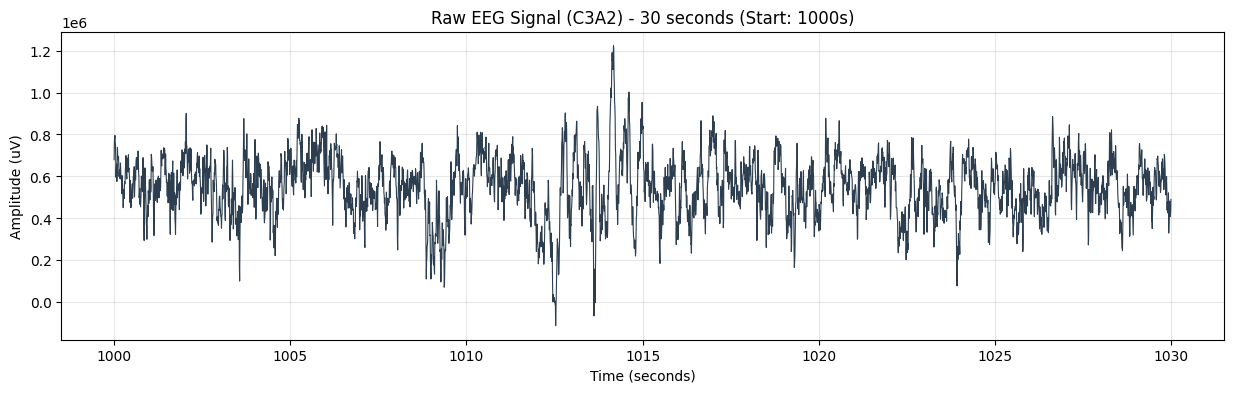


Hypnogram file: /content/drive/MyDrive/sleep_data/raw_dataset/ucd/ucddb002_stage.txt


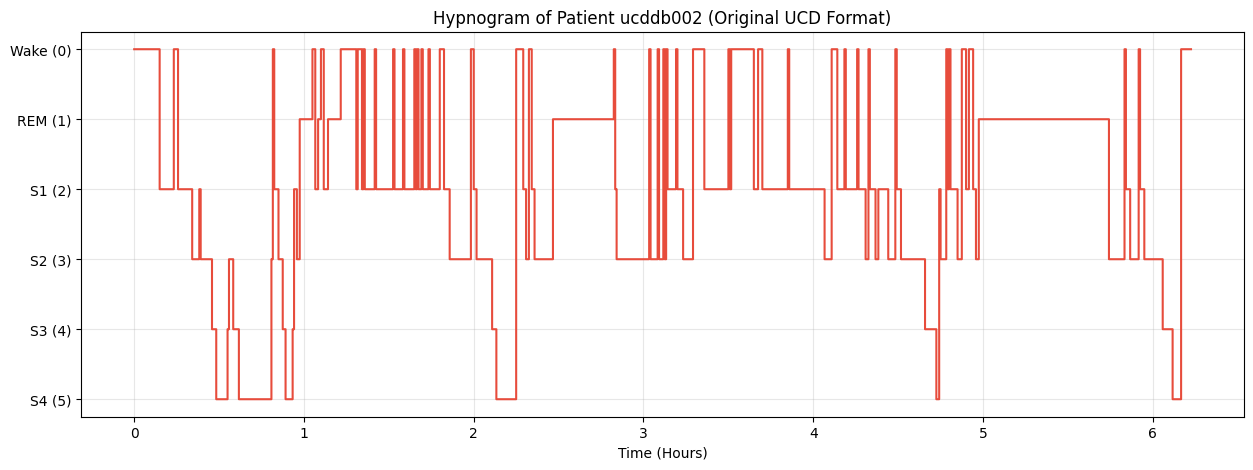

In [17]:
vizualization(base_path + '/ucd', 'ucddb002')

#ETL

##Quality check

In [23]:
class UCDLabelMapping:
    '''
    Handles the process for UCD Sleep Apnea Database signals.
    Adapts the original logic to handle .txt hypnograms and C3-A2 channels.
    '''
    def __init__(self, output_dir, sfreq=100, epoch_sec=30):
        self.output_dir = output_dir
        self.sfreq = sfreq
        self.epoch_sec = epoch_sec

        # Make sure the folder exists
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

    def __load_and_clean_psg(self, psg_path):
        '''
        Loads the EDF, finds the best EEG channel (C3 or C4),
        resamples to 100Hz and applies Bandpass filter (0.3Hz - 35Hz).
        '''
        # 1. Load (MNE) - Suppress warnings
        mne.set_log_level('ERROR')
        raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)

        # 2. Dynamic Channel Selection (UCD Specific)
        # We search for C3-A2 or C4-A1
        target_ch = None
        for ch in raw.ch_names:
            if "C3" in ch and "A2" in ch:
                target_ch = ch
                break

        # Fallback to C4 or the first EEG channel found
        if target_ch is None:
            candidates = [ch for ch in raw.ch_names if "C3" in ch or "C4" in ch]
            if candidates:
                target_ch = candidates[0]
            else:
                raise ValueError(f"No valid EEG channel found in {raw.ch_names}")

        # 3. Pick channel
        raw.pick_channels([target_ch])

        # Optional: Rename the channel to something generic ("EEG") for consistency
        # raw.rename_channels({target_ch: 'EEG'})

        # 4. Resampling
        if raw.info['sfreq'] != self.sfreq:
            raw.resample(self.sfreq)

        # 5. Bandpass Filtering (0.3Hz - 35Hz) - Same as in your original pipeline
        raw.filter(l_freq=0.3, h_freq=35.0, verbose=False)

        return raw

    def __extract_events_from_txt(self, hypno_path):
        '''
        Reads UCD .txt hypnogram and manually creates MNE Events.
        MNE Events format: [sample_index, 0, event_id]
        '''
        # 1. Read raw labels (0, 1, 2...)
        raw_labels = np.loadtxt(hypno_path, dtype=int)

        # 2. Map UCD labels to Standard (DeepSleepNet)
        # UCD: 0=W, 1=REM, 2=S1, 3=S2, 4=S3, 5=S4
        # TGT: 0=W, 1=N1, 2=N2, 3=N3, 4=REM

        mapped_labels = np.zeros_like(raw_labels)
        mapped_labels[raw_labels == 0] = 0 # W
        mapped_labels[raw_labels == 1] = 4 # REM (IMPORTANT!)
        mapped_labels[raw_labels == 2] = 1 # N1
        mapped_labels[raw_labels == 3] = 2 # N2
        mapped_labels[raw_labels == 4] = 3 # N3
        mapped_labels[raw_labels == 5] = 3 # N3
        # Artifacts (6, 7) remain 0 (W) or can be ignored later

        # 3. Create Events Array
        # Each epoch has 30 seconds * sampling frequency samples
        samples_per_epoch = int(self.sfreq * self.epoch_sec)

        n_epochs = len(mapped_labels)

        # Build the event matrix (N, 3)
        events = np.zeros((n_epochs, 3), dtype=int)

        # Column 0: Sample Index (0, 3000, 6000...)
        events[:, 0] = np.arange(n_epochs) * samples_per_epoch

        # Column 2: Event ID (Label)
        events[:, 2] = mapped_labels

        # Event ID mapping for MNE Epochs (reverse dictionary)
        event_id = {
            'Sleep stage W': 0,
            'Sleep stage 1': 1,
            'Sleep stage 2': 2,
            'Sleep stage 3/4': 3,
            'Sleep stage R': 4
        }

        return events, event_id

    def __create_epochs(self, raw, events, event_id):
        '''Segments the signal using the manually created events.'''
        tmax = self.epoch_sec - 1. / raw.info['sfreq']

        # We must ensure we don't request epochs that exceed the signal length
        # (Sometimes the hypnogram is slightly longer than the EDF file)
        max_sample = len(raw.times)
        valid_events = events[events[:, 0] + (self.epoch_sec * self.sfreq) <= max_sample]

        epochs = mne.Epochs(
            raw,
            valid_events,
            event_id=event_id,
            tmin=0., tmax=tmax,
            baseline=None,
            preload=True,
            verbose=False,
            on_missing='ignore'
        )
        return epochs

    def __save_data(self, subject_id, epochs):
        '''Converts to uV and saves to .npz'''
        # X: (n_epochs, n_channels, n_samples)
        # Multiply by 1e6 to get microvolts
        X = epochs.get_data() * 1e6

        # MNE returns (Batch, Channel, Time), but DeepSleepNet often expects (Batch, Time, Channel)
        # Check the shape. If you need (N, 3000, 1), we transpose:
        X = np.moveaxis(X, 1, 2)

        # y: labels
        y = epochs.events[:, 2]

        save_path = os.path.join(self.output_dir, f"{subject_id}.npz")
        np.savez_compressed(save_path, x=X, y=y, fs=self.sfreq)

        return X.shape, y.shape

    def __process_single_subject(self, row):
        '''Pipeline wrapper.'''
        # Extract subject ID from filename (e.g., ucddb002)
        subject_id = os.path.splitext(os.path.basename(row['psg_path']))[0]

        if os.path.exists(os.path.join(self.output_dir, f"{subject_id}.npz")):
            return "Skipped (Exists)"

        try:
            # 1. Signal Processing
            raw = self.__load_and_clean_psg(row['psg_path'])

            # 2. Extract Events (Custom for UCD TXT)
            events, event_map = self.__extract_events_from_txt(row['hypno_path'])

            # 3. Windowing
            epochs = self.__create_epochs(raw, events, event_map)

            # 4. Save
            if len(epochs) > 0:
                x_shape, y_shape = self.__save_data(subject_id, epochs)
                return f"Success {x_shape}"
            else:
                return "Error: No epochs generated (mismatch lengths?)"

        except Exception as e:
            return f"Error: {str(e)}"

    def run(self, df):
        '''Iterates through validated files.'''
        print("Start UCD Labeling & ETL Process")
        print(f"Output: {self.output_dir}")

        results = []
        total_files = len(df)

        for i, (index, row) in enumerate(df.iterrows()):
            # Extract ID for reporting
            subj_id = os.path.basename(row['psg_path'])

            status = self.__process_single_subject(row)
            results.append({'id': subj_id, 'etl_status': status})

            # Print errors immediately
            if "Error" in status:
                print(f"Error {subj_id}: {status}")
            else:
                # Print progress every 5 files
                if (i + 1) % 5 == 0:
                    print(f"Progress: {i + 1}/{total_files} processed...")

        print("\nPipeline Finished.")
        return pd.DataFrame(results)

ucd_labeler = UCDLabelMapping('/content/ucd')
etl_results = ucd_labeler.run(validated_df)

print("\n--- Summary of Failures ---")
print(etl_results[~etl_results['etl_status'].str.contains('Success')])

del ucd_labeler

In [24]:
psg_files = sorted(glob.glob(os.path.join(base_path + '/ucd', "*.edf")))
hypno_files = sorted(glob.glob(os.path.join(base_path + '/ucd', "*_stage.txt")))

df_ucd = pd.DataFrame({
    'psg_path': psg_files,
    'hypno_path': hypno_files
})

validator = UCDDataQuality(df_ucd)
validated_df = validator._run_validation()
display(validated_df.head())

Pregătit pentru validarea a 25 pacienți.
Checking Hypnograms (UCD Format)...
Done checking hypnograms.

Checking PSG files (EDF Headers)...
Done checking PSG files.

=== UCD DATASET VALIDATION SUMMARY ===
Total Files: 25

No errors in Hypnograms.

No errors in PSG files.


,psg_path,hypno_path,hypno_status,hypno_duration,n_epochs,W,N1,N2,N3,REM,Artifact,hypno_error,psg_status,psg_duration,psg_ch_count,psg_error
0,/content/drive/MyDrive/sleep_data/raw_dataset/...,/content/drive/MyDrive/sleep_data/raw_dataset/...,OK,22440,748,121,213,172,87,155,0,,OK,22469.992188,14,
1,/content/drive/MyDrive/sleep_data/raw_dataset/...,/content/drive/MyDrive/sleep_data/raw_dataset/...,OK,26460,882,168,106,254,164,190,0,,OK,26477.992188,14,
2,/content/drive/MyDrive/sleep_data/raw_dataset/...,/content/drive/MyDrive/sleep_data/raw_dataset/...,OK,24780,826,309,89,251,52,125,0,,OK,24797.992188,14,
3,/content/drive/MyDrive/sleep_data/raw_dataset/...,/content/drive/MyDrive/sleep_data/raw_dataset/...,OK,24240,808,92,181,95,248,192,0,,OK,24266.992188,14,
4,/content/drive/MyDrive/sleep_data/raw_dataset/...,/content/drive/MyDrive/sleep_data/raw_dataset/...,OK,24390,813,84,56,414,127,132,0,,OK,24404.992188,14,


##Label Mapping & Epoch Segmentation

In [34]:
class UCDLabelMapping:
    '''
    Handles the process for UCD Sleep Apnea Database signals.
    Adapts the original logic to handle .txt hypnograms and C3-A2 channels.
    '''
    def __init__(self, output_dir, sfreq=100, epoch_sec=30):
        self.output_dir = output_dir
        self.sfreq = sfreq
        self.epoch_sec = epoch_sec
        # Make sure the folder exists
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

    def __load_and_clean_psg(self, psg_path):
        '''
        Loads the EDF, finds the best EEG channel (C3 or C4),
        resamples to 100Hz and applies Bandpass filter (0.3Hz - 35Hz).
        '''
        # 1. Load (MNE) - Suppress warnings
        mne.set_log_level('ERROR')
        raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)

        # 2. Dynamic Channel Selection (UCD Specific)
        # We search for C3-A2 or C4-A1
        target_ch = None
        for ch in raw.ch_names:
            if "C3" in ch and "A2" in ch:
                target_ch = ch
                break

        # Fallback to C4 or the first EEG channel found
        if target_ch is None:
            candidates = [ch for ch in raw.ch_names if "C3" in ch or "C4" in ch]
            if candidates:
                target_ch = candidates[0]
            else:
                raise ValueError(f"No valid EEG channel found in {raw.ch_names}")

        # 3. Pick channel
        raw.pick_channels([target_ch])

        # Optional: Rename the channel to something generic ("EEG") for consistency
        # raw.rename_channels({target_ch: 'EEG'})

        # 4. Resampling
        if raw.info['sfreq'] != self.sfreq:
            raw.resample(self.sfreq)

        # 5. Bandpass Filtering (0.3Hz - 35Hz) - Same as in your original pipeline
        raw.filter(l_freq=0.3, h_freq=35.0, verbose=False)

        return raw

    def __extract_events_from_txt(self, hypno_path):
        '''
        Reads UCD .txt hypnogram and manually creates MNE Events.
        MNE Events format: [sample_index, 0, event_id]
        '''
        # 1. Read raw labels (0, 1, 2...)
        raw_labels = np.loadtxt(hypno_path, dtype=int)

        # 2. Map UCD labels to Standard (DeepSleepNet)
        # UCD: 0=W, 1=REM, 2=S1, 3=S2, 4=S3, 5=S4
        # TGT: 0=W, 1=N1, 2=N2, 3=N3, 4=REM

        mapped_labels = np.zeros_like(raw_labels)
        mapped_labels[raw_labels == 0] = 0 # W
        mapped_labels[raw_labels == 1] = 4 # REM (IMPORTANT!)
        mapped_labels[raw_labels == 2] = 1 # N1
        mapped_labels[raw_labels == 3] = 2 # N2
        mapped_labels[raw_labels == 4] = 3 # N3
        mapped_labels[raw_labels == 5] = 3 # N3
        # Artifacts (6, 7) remain 0 (W) or can be ignored later

        # 3. Create Events Array
        # Each epoch has 30 seconds * sampling frequency samples
        samples_per_epoch = int(self.sfreq * self.epoch_sec)

        n_epochs = len(mapped_labels)

        # Build the event matrix (N, 3)
        events = np.zeros((n_epochs, 3), dtype=int)

        # Column 0: Sample Index (0, 3000, 6000...)
        events[:, 0] = np.arange(n_epochs) * samples_per_epoch

        # Column 2: Event ID (Label)
        events[:, 2] = mapped_labels

        # Event ID mapping for MNE Epochs (reverse dictionary)
        event_id = {
            'Sleep stage W': 0,
            'Sleep stage 1': 1,
            'Sleep stage 2': 2,
            'Sleep stage 3/4': 3,
            'Sleep stage R': 4
        }

        return events, event_id

    def __create_epochs(self, raw, events, event_id):
        '''Segments the signal using the manually created events.'''
        tmax = self.epoch_sec - 1. / raw.info['sfreq']

        # We must ensure we don't request epochs that exceed the signal length
        # (Sometimes the hypnogram is slightly longer than the EDF file)
        max_sample = len(raw.times)
        valid_events = events[events[:, 0] + (self.epoch_sec * self.sfreq) <= max_sample]

        epochs = mne.Epochs(
            raw,
            valid_events,
            event_id=event_id,
            tmin=0., tmax=tmax,
            baseline=None,
            preload=True,
            verbose=False,
            on_missing='ignore'
        )
        return epochs

    def __save_data(self, subject_id, epochs):
        '''Converts to uV and saves to .npz'''
        # X: (n_epochs, n_channels, n_samples)
        # Multiply by 1e6 to get microvolts
        X = epochs.get_data() * 1e6

        # MNE returns (Batch, Channel, Time), but DeepSleepNet often expects (Batch, Time, Channel)
        # Check the shape. If you need (N, 3000, 1), we transpose:
        X = np.moveaxis(X, 1, 2)

        # y: labels
        y = epochs.events[:, 2]

        save_path = os.path.join(self.output_dir, f"{subject_id}.npz")
        np.savez_compressed(save_path, x=X, y=y, fs=self.sfreq)

        return X.shape, y.shape

    def __process_single_subject(self, row):
        '''Pipeline wrapper.'''
        # Extract subject ID from filename (e.g., ucddb002)
        subject_id = os.path.splitext(os.path.basename(row['psg_path']))[0]

        if os.path.exists(os.path.join(self.output_dir, f"{subject_id}.npz")):
            return "Skipped (Exists)"

        try:
            # 1. Signal Processing
            raw = self.__load_and_clean_psg(row['psg_path'])

            # 2. Extract Events (Custom for UCD TXT)
            events, event_map = self.__extract_events_from_txt(row['hypno_path'])

            # 3. Windowing
            epochs = self.__create_epochs(raw, events, event_map)

            # 4. Save
            if len(epochs) > 0:
                x_shape, y_shape = self.__save_data(subject_id, epochs)
                return f"Success {x_shape}"
            else:
                return "Error: No epochs generated (mismatch lengths?)"

        except Exception as e:
            return f"Error: {str(e)}"

    def run(self, df):
        '''Iterates through validated files.'''
        print("Start UCD Labeling & ETL Process")
        print(f"Output: {self.output_dir}")

        results = []
        total_files = len(df)

        for i, (index, row) in enumerate(df.iterrows()):
            # Extract ID for reporting
            subj_id = os.path.basename(row['psg_path'])

            status = self.__process_single_subject(row)
            results.append({'id': subj_id, 'etl_status': status})

            # Print errors immediately
            if "Error" in status:
                print(f"Error {subj_id}: {status}")
            else:
                # Print progress every 5 files
                if (i + 1) % 5 == 0:
                    print(f"Progress: {i + 1}/{total_files} processed...")

        print("\nPipeline Finished.")
        return pd.DataFrame(results)

ucd_labeler = UCDLabelMapping(original_dir)
etl_results = ucd_labeler.run(validated_df)

# Error check
print("\n--- Summary of Failures ---")
display(etl_results[~etl_results['etl_status'].str.contains('Success')])

# Cleanup
del ucd_labeler

Start UCD Labeling & ETL Process
Output: /content/ucd
Progress: 5/25 processed...
Progress: 10/25 processed...
Progress: 15/25 processed...
Progress: 20/25 processed...
Progress: 25/25 processed...

Pipeline Finished.

--- Summary of Failures ---
Empty DataFrame
Columns: [id, etl_status]
Index: []


##Data distribution analysis

25 process files.

=== DATA DISTRIBUTION (UCD Dataset) ===
Total Epochs: 20789


,Class,Count,Percentage
0,Wake (W),4722,22.713935
1,N1,3403,16.369234
2,N2,6985,33.599500
3,Deep (N3),2663,12.809659
4,REM,3016,14.507672


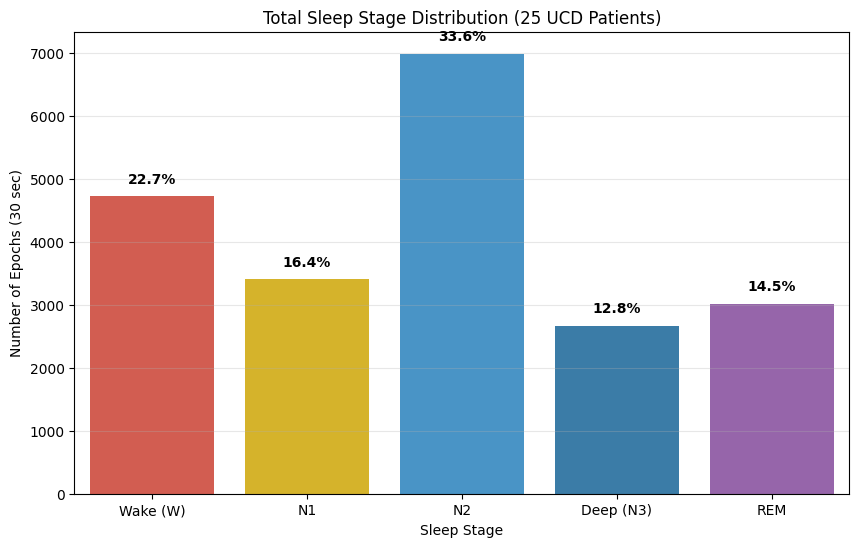

In [35]:
files = glob.glob(os.path.join(original_dir, "*.npz"))
print(f"{len(files)} process files.")

# Dictionary for counting
class_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
class_names = {0: 'Wake (W)', 1: 'N1', 2: 'N2', 3: 'Deep (N3)', 4: 'REM'}

total_epochs = 0

# 2. Iterate and count (very fast, we only load Y)
for f in files:
    data = np.load(f)
    y = data['y']

    # Count occurrences of each class in this file
    unique, counts = np.unique(y, return_counts=True)

    for cls, count in zip(unique, counts):
        if cls in class_counts:
            class_counts[cls] += count
            total_epochs += count

# 3. Create DataFrame for visualization
df_stats = pd.DataFrame([
    {'Class': class_names[k], 'Count': v, 'Percentage': (v/total_epochs)*100}
    for k, v in class_counts.items()
])

# 4. Tabular Display
print("\n=== DATA DISTRIBUTION (UCD Dataset) ===")
print(f"Total Epochs: {total_epochs}")
display(df_stats)

# 5. Graphical View
plt.figure(figsize=(10, 6))
# Barplot with sleep-specific colors
colors = ['#e74c3c', '#f1c40f', '#3498db', '#2980b9', '#9b59b6']  # W=Red, N1=Yellow, N2=Blue, N3=Blue, REM=Purple
sns.barplot(x='Class', y='Count', data=df_stats, palette=colors)

# Add percentage labels to the bars
for index, row in df_stats.iterrows():
    plt.text(index, row.Count + (total_epochs*0.01), f"{row.Percentage:.1f}%",
             color='black', ha="center", fontweight='bold')

plt.title(f"Total Sleep Stage Distribution ({len(files)} UCD Patients)")
plt.ylabel("Number of Epochs (30 sec)")
plt.xlabel("Sleep Stage")
plt.grid(axis='y', alpha=0.3)
plt.show()

#UCD vs Sleep EDF

Files found:
  - Sleep-EDF Healthy (SC): 23
  - Sleep-EDF Mild/Meds (ST): 7
  - UCD Apnea (Sever): 25


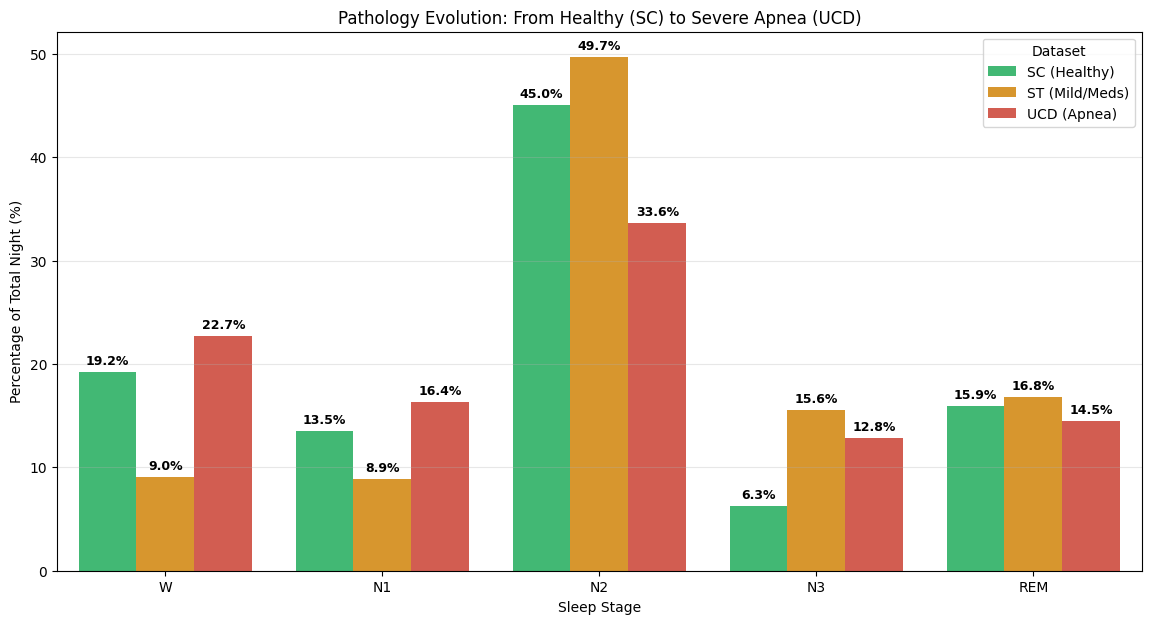

In [38]:
def get_counts(file_list):
    """Loads files and counts epochs for each class."""
    counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
    if not file_list:
        return counts, 0

    total = 0
    for f in file_list:
        try:
            y = np.load(f)['y']
            u, c = np.unique(y, return_counts=True)
            for cls, count in zip(u, c):
                if cls in counts:
                    counts[cls] += count
                    total += count
        except Exception as e:
            print(f"Error reading {os.path.basename(f)}: {e}")

    return counts, total

# 1. Identify files
all_test_files = glob.glob(os.path.join(path_sleep_edf, "*.npz"))
ucd_files = glob.glob(os.path.join(original_dir, "*.npz"))

# Separate SC from ST in the test folder
sc_files = [f for f in all_test_files if "SC" in os.path.basename(f)]
st_files = [f for f in all_test_files if "ST" in os.path.basename(f)]

print(f"Files found:")
print(f"  - Sleep-EDF Healthy (SC): {len(sc_files)}")
print(f"  - Sleep-EDF Mild/Meds (ST): {len(st_files)}")
print(f"  - UCD Apnea (Severe): {len(ucd_files)}")

# 2. Compute distributions
datasets = [
    ('SC (Healthy)', sc_files),
    ('ST (Mild/Meds)', st_files),
    ('UCD (Apnea)', ucd_files)
]

plot_data = []
class_names = {0: 'W', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}

for label, files in datasets:
    if not files:
        continue

    counts, total = get_counts(files)
    if total == 0:
        continue

    for cls_idx in range(5):
        percentage = (counts[cls_idx] / total) * 100
        plot_data.append({
            'Dataset': label,
            'Stadiu': class_names[cls_idx],
            'Procent': percentage
        })

df_compare = pd.DataFrame(plot_data)

# 3. Visualization
if not df_compare.empty:
    plt.figure(figsize=(14, 7))

    # Grouped Barplot
    ax = sns.barplot(
        x='Stadiu', y='Procent', hue='Dataset', data=df_compare,
        palette=['#2ecc71', '#f39c12', '#e74c3c']  # Green, Orange, Red
    )

    plt.title("Pathology Evolution: From Healthy (SC) to Severe Apnea (UCD)")
    plt.ylabel("Percentage of Total Night (%)")
    plt.xlabel("Sleep Stage")
    plt.grid(axis='y', alpha=0.3)

    # Add value labels
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(
                f'{p.get_height():.1f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 8),
                textcoords='offset points', fontsize=9, fontweight='bold'
            )

    plt.show()

#Split in train, val and test

In [39]:
destination_dir = '/content/drive/MyDrive/sleep_data/process_dataset'

# --- SPLIT LOGIC ---
def distribute_ucd_files():
    # 1. Find UCD files
    ucd_files = glob.glob(os.path.join(original_dir, "*.npz"))

    if not ucd_files:
        print(f"Error, no files found {original_dir}")
        return

    print(f"Found {len(ucd_files)} UCD files.")

    # 2. Perform the split only for UCD (70% Train, 15% Val, 15% Test)
    # Step A: Separate Train (70%) from the remaining 30%
    train_files, temp_files = train_test_split(ucd_files, test_size=0.30, random_state=42)

    # Step B: Split the remaining files in half (15% Val, 15% Test)
    val_files, test_files = train_test_split(temp_files, test_size=0.50, random_state=42)

    print(f"UCD Split Planning:")
    print(f" Train: {len(train_files)} files")
    print(f" Val: {len(val_files)} files")
    print(f" Test: {len(test_files)} files")

    # 3. Move files into the existing folders
    splits = {
        'train': train_files,
        'val':   val_files,
        'test':  test_files
    }

    for subset, files in splits.items():
        # Target path (e.g., .../process_dataset/train)
        target_folder = os.path.join(destination_dir, subset)

        # Ensure the folder exists (even though it should already exist)
        if not os.path.exists(target_folder):
            os.makedirs(target_folder)

        for f in files:
            file_name = os.path.basename(f)
            dest_path = os.path.join(target_folder, file_name)

            shutil.move(f, dest_path)

    print(f"\nDone!")

distribute_ucd_files()

Found 25 UCD files.
UCD Split Planning:
 Train: 17 files
 Val: 4 files
 Test: 4 files

Done!


#Class distribution

CSV save: class_distribution.csv


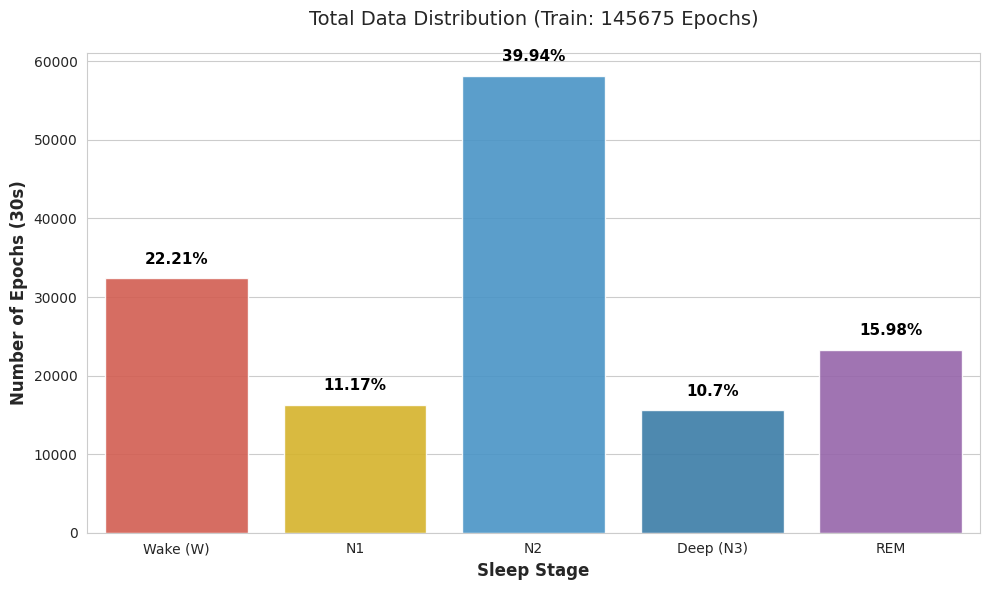

In [51]:
class_names = {
    0: 'Wake (W)',
    1: 'N1',
    2: 'N2',
    3: 'Deep (N3)',
    4: 'REM'
}

output_csv_name = 'class_distribution.csv'
drive_path = '/content/drive/MyDrive/sleep_data/'

def save_distribution_to_csv_and_plot_clean(counts, weights, output_filename):
    data = []
    total_samples = sum(counts.values())

    # 1. Build the data
    for cls_id in range(5):
        count = counts.get(cls_id, 0)
        weight = weights.get(cls_id, 1.0)
        label = class_names.get(cls_id, 'Unknown')

        percentage = (count / total_samples * 100) if total_samples > 0 else 0

        data.append({
            'Class_ID': cls_id,
            'Class_Label': label,
            'Count': count,
            'Percentage (%)': round(percentage, 2),
            'Weight': round(weight, 4)
        })

    df = pd.DataFrame(data)

    # 2. Save CSV (Includes weights for training)
    df.to_csv(output_filename, index=False)
    print(f"CSV save: {output_filename}")

    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))

    # Sleep‑specific colors
    palette = ['#e74c3c', '#f1c40f', '#3498db', '#2980b9', '#9b59b6']

    # Simple barplot
    ax = sns.barplot(x='Class_Label', y='Count', data=df, palette=palette, alpha=0.9)

    plt.xlabel('Sleep Stage', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Epochs (30s)', fontsize=12, fontweight='bold')
    plt.title(f'Total Data Distribution (Train: {total_samples} Epochs)', fontsize=14, pad=20)

    # Add percentage labels on bars
    for p, percentage in zip(ax.patches, df['Percentage (%)']):
        height = p.get_height()
        ax.text(
            p.get_x() + p.get_width() / 2.,
            height + (total_samples * 0.01),
            f'{percentage}%',
            ha="center",
            va="bottom",
            fontsize=11,
            fontweight='bold',
            color='black'
        )

    plt.tight_layout()
    plt.show()

save_distribution_to_csv_and_plot_clean(counts_dict, final_weights, output_csv_name)

---
# Conclusions and Next Step

In this notebook we have accomplished:
1. Download the Apnea Dataset
2. Apply tranformation to look like the SC/ ST datasets.
3. Split between train, val and test.

The next step, AI/ML apply [textul linkului](https://)